In [1]:
#!pip install janome

import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from torch import nn, Tensor
import torch.nn.functional as F
#from torchtext.vocab import vocab
#import torchtext.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms
import numpy as np
import math
import janome
from janome.tokenizer import Tokenizer
#import spacy
from collections import Counter
from torch.utils.data.sampler import SubsetRandomSampler
import time
#from torchtext.vocab import build_vocab_from_iterator
import levenshtein
import json
import pickle
from timm.scheduler import CosineLRScheduler
import nltk
from nltk import bleu_score
from torch.nn.init import constant_, xavier_uniform_
from torch.nn.parameter import Parameter
from transformers import  get_linear_schedule_with_warmup
from collections import OrderedDict
import gc

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device( "cpu")

In [3]:
with open( "corpus/id_to_word_s.pkl", "rb" ) as f:
    token_list = pickle.load(f)
with open( "corpus/id_to_word_t.pkl", "rb" ) as f:
    token_list_en = pickle.load(f)
with open( "corpus/word_to_id_s.pkl", "rb" ) as f:
    idx_list = pickle.load(f)
with open( "corpus/word_to_id_t.pkl", "rb" ) as f:
    idx_list_en = pickle.load(f)

#token_list[4] = '<blank>'
#token_list_en[4] = '<blank>'
#idx_list['<pad>'] = 4
#idx_list_en['<pad>'] = 4

pad_idx_s = idx_list['<pad>']
pad_idx_t = idx_list_en['<pad>']

#enc_vocab_size, dec_vocab_size = len(token_list) - 1, len(token_list_en) - 1
enc_vocab_size, dec_vocab_size = len(token_list), len(token_list_en)
print(enc_vocab_size, dec_vocab_size)

49528 20556


In [4]:
a = torch.tensor([ 0, 1,2,3,4,5,6 ])

#print( token_list[2] )

#n = 0

#ii = [ i for i in a ]

#print( ii )

b = [ token_list[i.item()] for i in a ]

print( b )


d = idx_list['<pad>']

print( d )

['<pad>', '<sos>', '<eos>', '<unk>', '<blank>', '<mask>', 'der']
0


In [5]:
class SequenceDataset(Dataset):
    ''' ミニバッチデータを作成するクラス
        torch.utils.data.Datasetクラスを継承し，
        以下の関数を定義する
        __len__: 総サンプル数を出力する関数
        __getitem__: 1サンプルのデータを出力する関数
    feat_scp:  特徴量リストファイル
    label_scp: ラベルファイル
    feat_mean: 特徴量の平均値ベクトル
    feat_std:  特徴量の次元毎の標準偏差を並べたベクトル 
    pad_index: バッチ化の際にフレーム数を合わせる
               ためにpaddingする整数値
    splice:    前後(splice)フレームを特徴量を結合する
               splice=1とすると，前後1フレーム分結合
               するので次元数は3倍になる．
               splice=0の場合は何もしない
    '''
    def __init__(self, 
                 et,
                 pad_index_s,
                 pad_index_t
                 ):

        # 読み込みながら情報を取得する
        self.pad_index_s = pad_index_s
        self.pad_index_t = pad_index_t
        print( "pad_index_s:", self.pad_index_s )
        print( "pad_index_t:", self.pad_index_t )
        self.en_list = []
        self.en_lens = []
        self.et_list = []
        self.et_lens = []
        self.num_data = 0
        for line in et:
            # 各行をスペースで区切り，
            # リスト型の変数にする
            self.en_list.append( line['target'] )
            self.en_lens.append( len( line['target']) )
            #self.en_att_list.append( line['target']['attention_mask'] )

            self.et_list.append( line['source'] )
            self.et_lens.append( len( line['source']) )
            #self.et_att_list.append( line['source']['attention_mask'] )
            self.num_data += 1

        #self.en_list = np.int64( np.array( self.en_list ) )
        #self.et_list = np.int64( np.array( self.et_list ) )
        self.en_lens = np.int64( np.array( self.en_lens ) )
        self.et_lens = np.int64( np.array( self.et_lens ) )

        # フレーム数の最大値を得る
        self.max_en_len = np.max(self.en_lens)
        # ラベル長の最大値を得る
        self.max_et_len = np.max(self.et_lens)

        for n in range(self.num_data):
            if n % 10000 == 0:
                print( "n:", n )
            # 埋めるフレームの数
            # = 最大フレーム数 - 自分のフレーム数
            pad_len = self.max_en_len - self.en_lens[n]
            # pad_indexの値で埋める
            tmp = self.en_list[n]
            self.en_list[n] = np.pad( tmp, (0, pad_len), mode='constant', constant_values=(self.pad_index_t, self.pad_index_t ))
            pad_len = self.max_et_len - self.et_lens[n]
            # pad_indexの値で埋める
            self.et_list[n] = np.pad(self.et_list[n],[0, pad_len],mode='constant', constant_values=self.pad_index_s)

        self.en_list = np.int64( np.array( self.en_list ) )
        self.et_list = np.int64( np.array( self.et_list ) )

    def __len__(self):
        ''' 学習データの総サンプル数を返す関数
        本実装では発話単位でバッチを作成するため，
        総サンプル数=発話数である．
        '''
        return self.num_data


    def __getitem__(self, idx):
        ''' サンプルデータを返す関数
        本実装では発話単位でバッチを作成するため，
        idx=発話番号である．
        '''

        # ラベル
        et = self.et_list[idx]
        et_len = self.et_lens[idx]

        # 発話ID
        en = self.en_list[idx]
        en_len = self.en_lens[idx]

        # 特徴量，ラベル，フレーム数，
        # ラベル長，発話IDを返す
        #return (jps, jp_lens, ens,  en_lens)
        return (et, et_len, en, en_len )


In [6]:
with open("data_test_it_unused.pkl", mode="rb") as f:
#with open("data_test_it.pkl", mode="rb") as f:
    it_test = pickle.load(f)

print( "it_test:", len( it_test ) )

test_dataset = SequenceDataset( it_test, pad_idx_s, pad_idx_t )
    
batch_size = 20
#num_workers = 4 if torch.cuda.is_available() else 0
num_workers = 0 if device == torch.device( 'cpu' ) else 4

test_loader = DataLoader(test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers)    

print( len( test_loader ) )
#Iter = iter(train_loader)
#xdata, xatt, ydata, yatt = next(Iter) #教師データ、ラベルデータ
#print(xdata, xatt, ydata, yatt)     

it_test: 500
pad_index_s: 0
pad_index_t: 0
n: 0
25


In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        #self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        #return self.dropout(x)
        return x

In [8]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=5000):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        positions = torch.arange(start=0, end=seq, step=1, device=x.device).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

In [9]:
class fPositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, name, max_len: int=5000):
        super().__init__()

        #self.pos_emb = nn.Embedding(max_len, dim_embedding)
        self.name = name
        
    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor, weights):
        seq = x.shape[1]
        positions = torch.arange(start=0, end=seq, step=1, device=x.device).to(torch.long)
        #positions = self.pos_emb(positions)[:seq,:]
        positions = F.embedding( positions, weights[self.name] )[:seq,:]
        
        return positions

In [10]:
class MHA(nn.Module):
    '''
    自己アテンション
    dim_hidden: 入力特徴量の次元
    num_heads : マルチヘッドアテンションのヘッド数
    qkv_bias  : クエリなどを生成する全結合層のバイアスの有無
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 qkv_bias: bool=False):
        super().__init__()

        # 特徴量を各ヘッドのために分割するので、
        # 特徴量次元をヘッド数で割り切れるか検証
        assert dim_hidden % num_heads == 0

        self.num_heads = num_heads

        # ヘッド毎の特徴量次元
        dim_head = dim_hidden // num_heads

        # ソフトマックスのスケール値
        self.scale = dim_head ** -0.5

        # ヘッド毎にクエリ、キーおよびバリューを生成するための全結合層
        self.proj_in_q = nn.Linear(
            dim_hidden, dim_hidden, bias=qkv_bias)
        self.proj_in_k = nn.Linear(
            dim_hidden, dim_hidden, bias=qkv_bias)
        self.proj_in_v = nn.Linear(
            dim_hidden, dim_hidden, bias=qkv_bias)

        #self.in_proj_weight = nn.Parameter( torch.randn( dim_hidden * 3, dim_hidden ) )
        #self.in_proj_bias = nn.Parameter( torch.randn( dim_hidden * 3 ) )
        #self.in_proj_weight = Parameter( torch.empty( dim_hidden * 3, dim_hidden ) )
        #self.in_proj_bias = Parameter( torch.empty( dim_hidden * 3 ) )

        # 各ヘッドから得られた特徴量を一つにまとめる全結合層
        self.proj_out = nn.Linear(dim_hidden, dim_hidden)
        
        #self._reset_parameters()
        
    #def _reset_parameters(self):
    #    xavier_uniform_( self.in_proj_weight )
    #    constant_( self.in_proj_bias, 0.0 )

    def split_head(self, x):
        x = torch.tensor_split(x, self.num_heads, dim = 2)
        x = torch.stack(x, dim = 1)
        return x

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: torch.Tensor):

        #bs_q, ns_q, ds_q = q.size()
        #bs_k, ns_k, ds_k = k.size()
        
        ##  k = v assumpotion
        #if q is k:
        #    qkv = q @ self.in_proj_weight.transpose(-2,-1) + self.in_proj_bias
        #    qkv = qkv.view( bs_q, ns_q, 3, ds_q )
        #    q, k, v = torch.unbind( qkv, dim = 2 )
        #else:
        #    W_q, W_kv = self.in_proj_weight.split([ds_q, ds_q * 2])
        #    b_q, b_kv = self.in_proj_bias.split([ds_q, ds_q * 2])
        #    q = q @ W_q.transpose(-2,-1) + b_q
        #    kv =  k @ W_kv.transpose(-2,-1) + b_kv
        #    kv = kv.view( bs_k, ns_k, 2, ds_k )
        #    k, v = torch.unbind( kv, dim = 2 )
        
        q = self.proj_in_q(q)
        k = self.proj_in_k(k)
        v = self.proj_in_v(v)
        
        q = self.split_head(q)
        k = self.split_head(k)
        v = self.split_head(v)

        # クエリとキーの行列積とアテンションの計算(今回マスクは不使用)
        # attnは[バッチサイズ, ヘッド数, 特徴量数, 特徴量数]
        attn = q.matmul(k.transpose(-2, -1))
        #print( "attn size:", attn.size() )
        #print( "mask size:", mask.size() )
        if mask is not None:
            attn = attn.masked_fill_(mask, -torch.finfo(torch.float).max)
        attn = (attn * self.scale).softmax(dim=-1)

        # アテンションとバリューの行列積によりバリューを収集
        # xは[バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        x = attn.matmul(v)

        # permute関数により
        # [バッチサイズ, 特徴量数, ヘッド数, ヘッドの特徴量次元]
        # flatten関数により全てのヘッドから得られる特徴量を連結して、
        # [バッチサイズ, 特徴量数, ヘッド数 * ヘッドの特徴量次元]
        x = x.permute(0, 2, 1, 3).flatten(2)
        x = self.proj_out(x)

        return x


In [11]:
class feMHA(nn.Module):
    '''
    自己アテンション
    dim_hidden: 入力特徴量の次元
    num_heads : マルチヘッドアテンションのヘッド数
    qkv_bias  : クエリなどを生成する全結合層のバイアスの有無
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 qkv_bias: bool=False):
        super().__init__()

        # 特徴量を各ヘッドのために分割するので、
        # 特徴量次元をヘッド数で割り切れるか検証
        assert dim_hidden % num_heads == 0

        self.num_heads = num_heads

        # ヘッド毎の特徴量次元
        dim_head = dim_hidden // num_heads

        # ソフトマックスのスケール値
        self.scale = dim_head ** -0.5

        # ヘッド毎にクエリ、キーおよびバリューを生成するための全結合層
        #self.proj_in = nn.Linear(
        #    dim_hidden, dim_hidden * 3, bias=qkv_bias)

        # 各ヘッドから得られた特徴量を一つにまとめる全結合層
        #self.proj_out = nn.Linear(dim_hidden, dim_hidden)

    def split_head(self, x):
        x = torch.tensor_split(x, self.num_heads, dim = 2)
        x = torch.stack(x, dim = 1)
        return x

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, q: torch.Tensor, k: torch.Tensor,  v: torch.Tensor, mask: torch.Tensor, i, weights ):
        bs, ns = q.shape[:2]

        #qkv = self.proj_in(x)
        q = F.linear(q, weights['encoder.encoder_layers.' + str(i) + '.attention.proj_in_q.weight'], weights['encoder.encoder_layers.' + str(i) + '.attention.proj_in_q.bias'])
        k = F.linear(k, weights['encoder.encoder_layers.' + str(i) + '.attention.proj_in_k.weight'], weights['encoder.encoder_layers.' + str(i) + '.attention.proj_in_k.bias'])
        v = F.linear(v, weights['encoder.encoder_layers.' + str(i) + '.attention.proj_in_v.weight'], weights['encoder.encoder_layers.' + str(i) + '.attention.proj_in_v.bias'])

        q = self.split_head( q )
        k = self.split_head( k )
        v = self.split_head( v )

        # クエリとキーの行列積とアテンションの計算(今回マスクは不使用)
        # attnは[バッチサイズ, ヘッド数, 特徴量数, 特徴量数]
        attn = q.matmul(k.transpose(-2, -1))
        if mask is not None:
            attn = attn.masked_fill_(mask, -torch.finfo(torch.float).max)
        attn = (attn * self.scale).softmax(dim=-1)

        # アテンションとバリューの行列積によりバリューを収集
        # xは[バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        x = attn.matmul(v)

        # permute関数により
        # [バッチサイズ, 特徴量数, ヘッド数, ヘッドの特徴量次元]
        # flatten関数により全てのヘッドから得られる特徴量を連結して、
        # [バッチサイズ, 特徴量数, ヘッド数 * ヘッドの特徴量次元]
        x = x.permute(0, 2, 1, 3).flatten(2)
        #x = self.proj_out(x)
        x = F.linear(x, weights['encoder.encoder_layers.' + str(i) + '.attention.proj_out.weight'], weights['encoder.encoder_layers.' + str(i) + '.attention.proj_out.bias'])

        return x

In [12]:
class fdsMHA(nn.Module):
    '''
    自己アテンション
    dim_hidden: 入力特徴量の次元
    num_heads : マルチヘッドアテンションのヘッド数
    qkv_bias  : クエリなどを生成する全結合層のバイアスの有無
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 qkv_bias: bool=False):
        super().__init__()

        # 特徴量を各ヘッドのために分割するので、
        # 特徴量次元をヘッド数で割り切れるか検証
        assert dim_hidden % num_heads == 0

        self.num_heads = num_heads

        # ヘッド毎の特徴量次元
        dim_head = dim_hidden // num_heads

        # ソフトマックスのスケール値
        self.scale = dim_head ** -0.5

        # ヘッド毎にクエリ、キーおよびバリューを生成するための全結合層
        #self.proj_in = nn.Linear(
        #    dim_hidden, dim_hidden * 3, bias=qkv_bias)

        # 各ヘッドから得られた特徴量を一つにまとめる全結合層
        #self.proj_out = nn.Linear(dim_hidden, dim_hidden)

    def split_head(self, x):
        x = torch.tensor_split(x, self.num_heads, dim = 2)
        x = torch.stack(x, dim = 1)
        return x

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, q: torch.Tensor, k: torch.Tensor,  v: torch.Tensor, mask: torch.Tensor, i, weights ):
        bs, ns = q.shape[:2]

        #qkv = self.proj_in(x)
        #print( "size q:", q.size() )
        #print( "size weigths q:", weights['d_layers.' + str(i) + '.crossattn.proj_in_q.weight'].size() )
        #print( "size k:", k.size() )
        #print( "size weights k:", weights['d_layers.' + str(i) + '.crossattn.proj_in_k.weight'].size() )
        q = F.linear(q, weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_in_q.weight'], weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_in_q.bias'])
        k = F.linear(k, weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_in_k.weight'], weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_in_k.bias'])
        v = F.linear(v, weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_in_v.weight'], weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_in_v.bias'])

        q = self.split_head( q )
        k = self.split_head( k )
        v = self.split_head( v )

        # view関数により
        # [バッチサイズ, 特徴量数, QKV, ヘッド数, ヘッドの特徴量次元]
        # permute関数により
        # [QKV, バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        #qkv = qkv.view(
        #    bs, ns, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)

        # クエリ、キーおよびバリューに分解
        #q, k, v = qkv.unbind(0)

        # クエリとキーの行列積とアテンションの計算(今回マスクは不使用)
        # attnは[バッチサイズ, ヘッド数, 特徴量数, 特徴量数]
        attn = q.matmul(k.transpose(-2, -1))
        if mask is not None:
            attn = attn.masked_fill_(mask, -torch.finfo(torch.float).max)      
        attn = (attn * self.scale).softmax(dim=-1)

        # アテンションとバリューの行列積によりバリューを収集
        # xは[バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        x = attn.matmul(v)

        # permute関数により
        # [バッチサイズ, 特徴量数, ヘッド数, ヘッドの特徴量次元]
        # flatten関数により全てのヘッドから得られる特徴量を連結して、
        # [バッチサイズ, 特徴量数, ヘッド数 * ヘッドの特徴量次元]
        x = x.permute(0, 2, 1, 3).flatten(2)
        #x = self.proj_out(x)
        x = F.linear(x, weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_out.weight'], weights['decoder.decoder_layers.' + str(i) + '.selfattn.proj_out.bias'])

        return x

In [13]:
class fdcMHA(nn.Module):
    '''
    自己アテンション
    dim_hidden: 入力特徴量の次元
    num_heads : マルチヘッドアテンションのヘッド数
    qkv_bias  : クエリなどを生成する全結合層のバイアスの有無
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 qkv_bias: bool=False):
        super().__init__()

        # 特徴量を各ヘッドのために分割するので、
        # 特徴量次元をヘッド数で割り切れるか検証
        assert dim_hidden % num_heads == 0

        self.num_heads = num_heads

        # ヘッド毎の特徴量次元
        dim_head = dim_hidden // num_heads

        # ソフトマックスのスケール値
        self.scale = dim_head ** -0.5

        # ヘッド毎にクエリ、キーおよびバリューを生成するための全結合層
        #self.proj_in = nn.Linear(
        #    dim_hidden, dim_hidden * 3, bias=qkv_bias)

        # 各ヘッドから得られた特徴量を一つにまとめる全結合層
        #self.proj_out = nn.Linear(dim_hidden, dim_hidden)

    def split_head(self, x):
        x = torch.tensor_split(x, self.num_heads, dim = 2)
        x = torch.stack(x, dim = 1)
        return x

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, q: torch.Tensor, k: torch.Tensor,  v: torch.Tensor, mask: torch.Tensor, i, weights ):
        bs, ns = q.shape[:2]

        #qkv = self.proj_in(x)
        #print( "size q:", q.size() )
        #print( "size weigths q:", weights['d_layers.' + str(i) + '.crossattn.proj_in_q.weight'].size() )
        #print( "size k:", k.size() )
        #print( "size weights k:", weights['d_layers.' + str(i) + '.crossattn.proj_in_k.weight'].size() )
        q = F.linear(q, weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_in_q.weight'], weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_in_q.bias'])
        k = F.linear(k, weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_in_k.weight'], weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_in_k.bias'])
        v = F.linear(v, weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_in_v.weight'], weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_in_v.bias'])

        q = self.split_head( q )
        k = self.split_head( k )
        v = self.split_head( v )

        # view関数により
        # [バッチサイズ, 特徴量数, QKV, ヘッド数, ヘッドの特徴量次元]
        # permute関数により
        # [QKV, バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        #qkv = qkv.view(
        #    bs, ns, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)

        # クエリ、キーおよびバリューに分解
        #q, k, v = qkv.unbind(0)

        # クエリとキーの行列積とアテンションの計算(今回マスクは不使用)
        # attnは[バッチサイズ, ヘッド数, 特徴量数, 特徴量数]
        attn = q.matmul(k.transpose(-2, -1))
        if mask is not None:
            attn = attn.masked_fill_(mask, -torch.finfo(torch.float).max)      
        attn = (attn * self.scale).softmax(dim=-1)

        # アテンションとバリューの行列積によりバリューを収集
        # xは[バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        x = attn.matmul(v)

        # permute関数により
        # [バッチサイズ, 特徴量数, ヘッド数, ヘッドの特徴量次元]
        # flatten関数により全てのヘッドから得られる特徴量を連結して、
        # [バッチサイズ, 特徴量数, ヘッド数 * ヘッドの特徴量次元]
        x = x.permute(0, 2, 1, 3).flatten(2)
        #x = self.proj_out(x)
        x = F.linear(x, weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_out.weight'], weights['decoder.decoder_layers.' + str(i) + '.crossattn.proj_out.bias'])

        return x


In [14]:
class FNN(nn.Module):
    '''
    Transformerエンコーダ内の順伝播型ニューラルネットワーク
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, dim_feedforward: int):
        super().__init__()

        self.linear1 = nn.Linear(dim_hidden, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, dim_hidden)
        self.activation = nn.GELU()

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)

        return x


In [15]:
class feFNN(nn.Module):
    '''
    Transformerエンコーダ内の順伝播型ニューラルネットワーク
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, dim_feedforward: int):
        super().__init__()

        #self.linear1 = nn.Linear(dim_hidden, dim_feedforward)
        #self.linear2 = nn.Linear(dim_feedforward, dim_hidden)
        self.activation = nn.GELU()

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor, i, weights ):
        #x = self.linear1(x)
        x = F.linear(x, weights['encoder.encoder_layers.' + str(i) + '.fnn.linear1.weight'], weights['encoder.encoder_layers.' + str(i) + '.fnn.linear1.bias'])
        x = self.activation(x)
        #x = self.linear2(x)
        x = F.linear(x, weights['encoder.encoder_layers.' + str(i) + '.fnn.linear2.weight'], weights['encoder.encoder_layers.' + str(i) + '.fnn.linear2.bias'])

        return x


In [16]:
class fdFNN(nn.Module):
    '''
    Transformerエンコーダ内の順伝播型ニューラルネットワーク
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, dim_feedforward: int):
        super().__init__()

        #self.linear1 = nn.Linear(dim_hidden, dim_feedforward)
        #self.linear2 = nn.Linear(dim_feedforward, dim_hidden)
        self.activation = nn.GELU()

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor, i, weights ):
        #x = self.linear1(x)
        x = F.linear(x, weights['decoder.decoder_layers.' + str(i) + '.fnn.linear1.weight'], weights['decoder.decoder_layers.' + str(i) + '.fnn.linear1.bias'])
        x = self.activation(x)
        #x = self.linear2(x)
        x = F.linear(x, weights['decoder.decoder_layers.' + str(i) + '.fnn.linear2.weight'], weights['decoder.decoder_layers.' + str(i) + '.fnn.linear2.bias'])

        return x


In [17]:
class TransformerEncoderLayer(nn.Module):
    '''
    Transformerエンコーダ層
    dim_hidden     : 入力特徴量の次元
    num_heads      : ヘッド数
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 dim_feedforward: int, dropout: float = 0.0):
        super().__init__()

        self.attention = MHA(dim_hidden, num_heads, qkv_bias = True)
        self.fnn = FNN(dim_hidden, dim_feedforward)

        self.norm1 = nn.LayerNorm(dim_hidden)
        self.norm2 = nn.LayerNorm(dim_hidden)
        
        self.dropout = nn.Dropout( dropout )

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        ''' B2T
        x0 = x
        x = self.attention( x, x, x, mask )
        x = self.dropout( x )
        x = x + x0
        x = self.norm1(x)
        x1 = x
        x = self.fnn( x )
        x = self.dropout( x )
        x =  x + x1 + x0
        x = self.norm2( x )
        '''
        #pre-LN
        x0 = x
        x = self.norm1(x)
        x = self.attention( x, x, x, mask )
        x = self.dropout( x )
        x = x + x0
        x1 = x
        x = self.norm2( x )
        x = self.fnn( x )
        x = self.dropout( x )
        x =  x + x1
        
        return x 


In [18]:
class fTransformerEncoderLayer(nn.Module):
    '''
    Transformerエンコーダ層
    dim_hidden     : 入力特徴量の次元
    num_heads      : ヘッド数
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 dim_feedforward: int, dropout: float = 0.0):
        super().__init__()

        self.fattention = feMHA(dim_hidden, num_heads)
        self.fffn = feFNN(dim_hidden, dim_feedforward)
        self.dim_hidden = dim_hidden
        self.dropout = nn.Dropout( dropout )
        
    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor, mask: torch.Tensor, i, weights ):
        '''B2T
        x0 = x
        x = self.fattention( x, x, x, mask, i, weights )
        x = self.dropout( x )
        x = x + x0
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['encoder.encoder_layers.' + str(i) + '.norm1.weight'], bias=weights['encoder.encoder_layers.' + str(i) + '.norm1.bias'], eps=1e-05)
        x1 = x
        x = self.fffn( x, i, weights ) 
        x = self.dropout( x )
        x = x + x1 + x0
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['encoder.encoder_layers.' + str(i) + '.norm2.weight'], bias=weights['encoder.encoder_layers.' + str(i) + '.norm2.bias'], eps=1e-05)
        '''
        #pre-LN
        x0 = x
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['encoder.encoder_layers.' + str(i) + '.norm1.weight'], bias=weights['encoder.encoder_layers.' + str(i) + '.norm1.bias'], eps=1e-05)
        x = self.fattention( x, x, x, mask, i, weights )
        x = self.dropout( x )
        x = x + x0
        x1 = x
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['encoder.encoder_layers.' + str(i) + '.norm2.weight'], bias=weights['encoder.encoder_layers.' + str(i) + '.norm2.bias'], eps=1e-05)
        x = self.fffn( x, i, weights ) 
        x = self.dropout( x )
        x = x + x1

        return x

In [19]:
class TransformerDecoderLayer(nn.Module):
    '''
    Transformerエンコーダ層
    dim_hidden     : 入力特徴量の次元
    num_heads      : ヘッド数
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 dim_feedforward: int, dropout: float=0.0):
        super().__init__()

        self.selfattn = MHA(dim_hidden, num_heads, qkv_bias = True)
        self.crossattn = MHA(dim_hidden, num_heads, qkv_bias = True)
        self.fnn = FNN(dim_hidden, dim_feedforward)

        self.norm1 = nn.LayerNorm(dim_hidden)
        self.norm2 = nn.LayerNorm(dim_hidden)
        self.norm3 = nn.LayerNorm(dim_hidden)
        
        self.dropout = nn.Dropout(dropout)

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor, y: torch.Tensor,  self_mask: torch.Tensor,  cross_mask: torch.Tensor):
        '''B2T
        x0 = x
        x = self.selfattn( x, x, x, self_mask )
        x = self.dropout( x )
        x = x + x0
        x = self.norm1( x )
        x1 = x
        x = self.crossattn( x, y, y, cross_mask )
        x = self.dropout( x )
        x = x + x1
        x = self.norm2( x )
        x2 = x
        x = self.fnn( x )
        x = self.dropout( x )
        x = x + x2 + x0
        x = self.norm3( x )
        '''
        #pre-LN
        x0 = x
        x = self.norm1( x )
        x = self.selfattn( x, x, x, self_mask )
        x = self.dropout( x )
        x = x + x0
        x1 = x
        x = self.norm2( x )
        x = self.crossattn( x, y, y, cross_mask )
        x = self.dropout( x )
        x = x + x1
        x2 = x
        x = self.norm3( x )
        x = self.fnn( x )
        x = self.dropout( x )
        x = x + x2
        
        return x 


In [20]:
class fTransformerDecoderLayer(nn.Module):
    '''
    Transformerエンコーダ層
    dim_hidden     : 入力特徴量の次元
    num_heads      : ヘッド数
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 dim_feedforward: int, dropout: float = 0.0):
        super().__init__()

        self.fselfattn = fdsMHA(dim_hidden, num_heads)
        self.fcrossattn = fdcMHA(dim_hidden, num_heads)
        self.fffn = fdFNN(dim_hidden, dim_feedforward)
        self.dim_hidden = dim_hidden
        self.dropout = nn.Dropout(dropout)

        #self.norm1 = nn.LayerNorm(dim_hidden)
        #self.norm2 = nn.LayerNorm(dim_hidden)
        #self.norm3 = nn.LayerNorm(dim_hidden)

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor, y: torch.Tensor,  self_mask: torch.Tensor,  cross_mask: torch.Tensor, i, weights):
        '''B2T
        x0 = x
        x = self.fselfattn( x, x, x, self_mask, i, weights )
        x = self.dropout( x )
        x = x + x0
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['decoder.decoder_layers.' + str(i) + '.norm1.weight'], bias=weights['decoder.decoder_layers.' + str(i) + '.norm1.bias'], eps=1e-05)
        x1 = x
        x = self.fcrossattn( x, y, y, cross_mask, i, weights )
        x = self.dropout( x )
        x = x + x1
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['decoder.decoder_layers.' + str(i) + '.norm2.weight'], bias=weights['decoder.decoder_layers.' + str(i) + '.norm2.bias'], eps=1e-05)
        x2 = x
        x = self.fffn( x, i, weights )
        x = self.dropout( x ) 
        x = x + x2 + x0
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['decoder.decoder_layers.' + str(i) + '.norm3.weight'], bias=weights['decoder.decoder_layers.' + str(i) + '.norm3.bias'], eps=1e-05)
        '''
        #pre-LN
        x0 = x
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['decoder.decoder_layers.' + str(i) + '.norm1.weight'], bias=weights['decoder.decoder_layers.' + str(i) + '.norm1.bias'], eps=1e-05)
        x = self.fselfattn( x, x, x, self_mask, i, weights )
        x = self.dropout( x )
        x = x + x0
        x1 = x
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['decoder.decoder_layers.' + str(i) + '.norm2.weight'], bias=weights['decoder.decoder_layers.' + str(i) + '.norm2.bias'], eps=1e-05)
        x = self.fcrossattn( x, y, y, cross_mask, i, weights )
        x = self.dropout( x )
        x = x + x1
        x2 = x
        x = F.layer_norm(x, (self.dim_hidden,), weight=weights['decoder.decoder_layers.' + str(i) + '.norm3.weight'], bias=weights['decoder.decoder_layers.' + str(i) + '.norm3.bias'], eps=1e-05)
        x = self.fffn( x, i, weights )
        x = self.dropout( x ) 
        x = x + x2
        
        return x 


In [21]:
class TransformerEncoder(nn.Module):
    '''
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: FNNにおける中間特徴量の次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerエンコーダの層数
    '''
    def __init__(self, text_vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int,  num_layers: int, pad_index:int, dropout: float = 0.1 ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            text_vocab_size, dim_embedding, padding_idx=pad_index)        
        
        # 位置エンコーディング
        #self.pos_enc = PositionalEncoding(dim_embedding)
        self.pos_emb = PositionalEmbedding(dim_embedding)
        #self.dropout = nn.Dropout( dropout )
        
        # Transformerエンコーダ層
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(dim_hidden=dim_embedding, num_heads=num_heads, dim_feedforward = dim_feedforward, dropout = dropout )
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(dim_embedding)
       
        self.pad_index = pad_index
        self.dim_embedding = dim_embedding
        self.num_heads = num_heads

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    def forward(self, src: torch.Tensor, src_mask: torch.Tensor=None, src_padding_mask: torch.Tensor=None ):

        if src_padding_mask is not None and src_mask is None:
            mask = src_padding_mask[:,None,:,None]
            mask = mask.expand( (-1, self.num_heads, -1, src.size(1)))
        elif src_padding_mask is not None and src_mask is not None:
            mask1 = src_padding_mask[:,None,:,None]
            mask1 = mask1.expand( (-1, self.num_heads, -1, src.size(1)))
            mask2 = src_mask[None,None,:,:]
            mask2 = mask2.expand( ( src.size(0), self.num_heads, -1, -1 ) )
            mask = torch.logical_or(mask1, mask2 )
        elif src_padding_mask is None and src_mask is not None:
            mask = src_mask[None,None,:,:]
            mask = mask.padding( ( src.size(0), src.size(1), -1, -1 ) )
        else:
            mask = None

        x = self.embed( src ) * math.sqrt( self.dim_embedding )

        #x = self.pos_enc( x )
        position = self.pos_emb( x )
        x = x + position
        #x = self.dropout( x )
        #x = self.norm( x )
        
        # Transformerエンコーダ層を適用
        for layer in self.encoder_layers:
            x = layer( x, mask )

        x = self.norm(x)

        return x


In [22]:
class fTransformerEncoder(nn.Module):
    '''
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: FNNにおける中間特徴量の次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerエンコーダの層数
    '''
    def __init__(self, text_vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int,  num_layers: int, pad_idx:int, dropout: float = 0.1 ):
        super().__init__()

        # 単語埋め込み
        #self.embed = nn.Embedding(
        #    text_vocab_size, dim_embedding, padding_idx=pad_index)        
        
        # 位置エンコーディング
        #self.pos_enc = PositionalEncoding(dim_embedding)
        self.fpos_emb = fPositionalEmbedding(dim_embedding, "encoder.pos_emb.pos_emb.weight" )
        #self.dropout = nn.Dropout( dropout )
        
        # Transformerエンコーダ層
        self.fenclayer = fTransformerEncoderLayer(dim_hidden=dim_embedding, num_heads=num_heads, dim_feedforward = dim_feedforward, dropout = dropout )
        
        # ロジットを生成する前のレイヤー正規化と全結合
        #self.norm = nn.LayerNorm(dim_embedding)
        
        self.pad_idx = pad_idx
        self.dim_embedding = dim_embedding
        self.num_heads = num_heads
        self.num_layers = num_layers

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    def forward(self, src: torch.Tensor, src_mask: torch.Tensor=None, src_padding_mask: torch.Tensor=None, weights = None ):

        if src_padding_mask is not None and src_mask is None:
            mask = src_padding_mask[:,None,:,None]
            mask = mask.expand( (-1, self.num_heads, -1, src.size(1)))
        elif src_padding_mask is not None and src_mask is not None:
            mask1 = src_padding_mask[:,None,:,None]
            mask1 = mask1.expand( (-1, self.num_heads, -1, src.size(1)))
            mask2 = src_mask[None,None,:,:]
            mask2 = mask2.expand( ( src.size(0), self.num_heads, -1, -1 ) )
            mask = torch.logical_or(mask1, mask2 )
        elif src_padding_mask is None and src_mask is not None:
            mask = src_mask[None,None,:,:]
            mask = mask.padding( ( src.size(0), src.size(1), -1, -1 ) )
        else:
            mask = None

        #x = self.embed( src ) * math.sqrt( self.dim_embedding )
        x = F.embedding( src, weights['encoder.embed.weight'], padding_idx = self.pad_idx )  * math.sqrt( self.dim_embedding )
        
        #x = self.pos_enc( x )
        position = self.fpos_emb( x, weights )
        x = x + position
        #x = self.dropout( x )
        ##x = self.norm(x)
        #x = F.layer_norm(x, (self.dim_embedding,), weight=weights['encoder.norm.weight'], bias=weights['encoder.norm.bias'], eps=1e-05)
    
        # Transformerエンコーダ層を適用
        #for layer in self.encoder_layers:
        #    x = layer( x, mask )
        for block in range( self.num_layers ):
            x = self.fenclayer(x, mask, block, weights )

        #x = self.norm(x)
        x = F.layer_norm(x, (self.dim_embedding,), weight=weights['encoder.norm.weight'], bias=weights['encoder.norm.bias'], eps=1e-05)
        
        return x    

In [23]:
class TransformerDecoder(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    pad_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, 
                 pad_index: int, dropout: float=0.1, ds_rate: float=0.1 ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            vocab_size, dim_embedding, padding_idx=pad_index)
        
        # 位置エンコーディング
        #self.pos_enc = PositionalEncoding(dim_embedding)
        self.pos_emb = PositionalEmbedding(dim_embedding)
        #self.dropout = nn.Dropout( dropout )

        # Transformerデコーダ
        #self.decoder_layers = nn.ModuleList([
        #    TransformerDecoderLayer(
        #        dim_embedding, num_heads, dim_feedforward, dropout)
        #    for _ in range(num_layers)
        #])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(dim_hidden=dim_embedding, num_heads=num_heads, dim_feedforward = dim_feedforward, dropout = dropout)
            for _ in range(num_layers)
        ])

        # ロジットを生成する前のレイヤー正規化と全結合
        #self.norm = nn.LayerNorm(dim_embedding)
        
        # 単語出力分布計算
        self.linear = nn.Linear(dim_embedding, vocab_size)
        
        self.pad_index = pad_index
        self.dim_embedding = dim_embedding
        self.num_heads = num_heads



    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    #def forward(self, features: torch.Tensor, caption_lengths: torch.Tensor):
    #def forward(self, features: torch.Tensor, captions: torch.Tensor, padding_mask_src: torch.Tensor=None, \
    #            padding_mask_tgt: torch.Tensor=None, mask_tgt: torch.Tensor=None ):
    def forward(self, features: torch.Tensor, captions: torch.Tensor, memory_padding_mask: torch.Tensor=None, \
                tgt_padding_mask: torch.Tensor=None, tgt_mask: torch.Tensor=None ):

        #feature_lengths = torch.ones( (features.size(0) ), device=features.device ) * features.size(1)

        tgt = captions
        if tgt_padding_mask is not None and tgt_mask is not None:
            self_mask1 = tgt_padding_mask[:,None,:,None]
            self_mask1 = self_mask1.expand( (-1, self.num_heads, -1, tgt.size(1)))
            #print( "self_mask1:", self_mask1.size() )
            self_mask2 = tgt_mask[None,None,:,:]
            self_mask2 = self_mask2.expand( (tgt.size(0), self.num_heads, -1, -1 ))
            #print( "self_mask2:", self_mask2.size() )
            self_mask = torch.logical_or(self_mask1, self_mask2 )
            #print( "0 self_mask:", self_mask.size() )
        elif tgt_padding_mask is not None and tgt_mask is None:
            self_mask = tgt_padding_mask[:,None,:,None]
            self_mask = self_mask.expand( (-1, self.num_heads, -1, tgt.size(1)))
        elif tgt_padding_mask is None and tgt_mask is not None:
            #print("tgt_padding_mask is None")
            self_mask = tgt_mask[None,None,:,:]
            self_mask = self_mask.expand( (tgt.size(0), self.num_heads, -1, -1 ))
            #print( "0 self_mask size():", self_mask.size() )
        elif tgt_padding_mask is None and tgt_mask is None:
            self_mask = None
            
        if memory_padding_mask is not None:
            cross_mask = memory_padding_mask[:,None,None,:]
            cross_mask = cross_mask.expand((-1,self.num_heads, tgt.size(1), -1))
        else:
            cross_mask = None
        
        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = self.embed(captions) * math.sqrt( self.dim_embedding )
        seq = embeddings.shape[1]
        
        # 位置エンコーディング
        #embeddings = self.pos_enc( embeddings )
        positions = self.pos_emb(embeddings)
        embeddings = embeddings + positions
        #embeddings = self.dropout( embeddings )
        #embeddings = self.norm(embeddings)
        
        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        for layer in self.decoder_layers:
            embeddings = layer( embeddings, features, self_mask, cross_mask )

        
        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)
        #print( "argmax of preds:", torch.argmax( preds, dim = 2 ))
        return preds

In [24]:
class fTransformerDecoder(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    pad_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, 
                 pad_idx: int, dropout: float=0.1, ds_rate: float=0.1 ):
        super().__init__()

        # 単語埋め込み
        #self.embed = nn.Embedding(
        #    vocab_size, dim_embedding, padding_idx=pad_index)
        
        # 位置エンコーディング
        #self.pos_enc = PositionalEncoding(dim_embedding)
        self.fpos_emb = fPositionalEmbedding(dim_embedding, "decoder.pos_emb.pos_emb.weight" )
        #self.dropout = nn.Dropout( dropout )
        
        # Transformerデコーダ
        self.fdeclayer = fTransformerDecoderLayer(dim_hidden=dim_embedding, num_heads=num_heads, dim_feedforward = dim_feedforward, dropout = dropout )
        
        # 単語出力分布計算
        #self.linear = nn.Linear(dim_embedding, vocab_size)
        
        self.pad_idx = pad_idx
        self.dim_embedding = dim_embedding
        self.num_heads = num_heads
        self.num_layers = num_layers

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    def forward(self, features: torch.Tensor, captions: torch.Tensor, memory_padding_mask: torch.Tensor=None, \
                tgt_padding_mask: torch.Tensor=None, tgt_mask: torch.Tensor=None, weights = None ):

        tgt = captions
        if tgt_padding_mask is not None and tgt_mask is not None:
            self_mask1 = tgt_padding_mask[:,None,:,None]
            self_mask1 = self_mask1.expand( (-1, self.num_heads, -1, tgt.size(1)))
            #print( "self_mask1:", self_mask1.size() )
            self_mask2 = tgt_mask[None,None,:,:]
            self_mask2 = self_mask2.expand( (tgt.size(0), self.num_heads, -1, -1 ))
            #print( "self_mask2:", self_mask2.size() )
            self_mask = torch.logical_or(self_mask1, self_mask2 )
            #print( "0 self_mask:", self_mask.size() )
        elif tgt_padding_mask is not None and tgt_mask is None:
            self_mask = tgt_padding_mask[:,None,:,None]
            self_mask = self_mask.expand( (-1, self.num_heads, -1, tgt.size(1)))
        elif tgt_padding_mask is None and tgt_mask is not None:
            #print("tgt_padding_mask is None")
            self_mask = tgt_mask[None,None,:,:]
            self_mask = self_mask.expand( (tgt.size(0), self.num_heads, -1, -1 ))
            #print( "0 self_mask size():", self_mask.size() )
        elif tgt_padding_mask is None and tgt_mask is None:
            self_mask = None
            
        if memory_padding_mask is not None:
            cross_mask = memory_padding_mask[:,None,None,:]
            cross_mask = cross_mask.expand((-1,self.num_heads, tgt.size(1), -1))
        else:
            cross_mask = None
        
        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = F.embedding( captions, weights['decoder.embed.weight'], padding_idx = self.pad_idx )  * math.sqrt( self.dim_embedding )
        seq = embeddings.shape[1]
        
        # 位置エンコーディング
        #embeddings = self.pos_enc(embeddings)
        positions = self.fpos_emb( embeddings, weights )
        embeddings = embeddings + positions
        #embeddings = self.dropout( embeddings )
        ##embeddings = self.norm(embeddings)
        #embeddings = F.layer_norm(embeddings, (self.dim_embedding,), weight=weights['decoder.norm.weight'], bias=weights['decoder.norm.bias'], eps=1e-05)
        
        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        #for layer in self.decoder_layers:
        #    #embeddings = layer( embeddings, features, tgt_key_padding_mask = padding_mask_tgt, \
        #    #                                memory_key_padding_mask = padding_mask_src, tgt_is_causal = True, tgt_mask = mask_tgt )
        for block in range( self.num_layers ):
            embeddings = self.fdeclayer(embeddings, features, self_mask, cross_mask, block, weights )
  
        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        #preds = self.linear(embeddings)
        preds = F.linear( embeddings, weights['decoder.linear.weight'], weights['decoder.linear.bias'] )
        #print( "argmax of preds:", torch.argmax( preds, dim = 2 ))
        return preds

In [25]:
class Transformer(nn.Module):
    def __init__(self, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, enc_vocab_size: int, dec_vocab_size: int,
                 j_pad_index: int,e_pad_index: int, dropout: float=0.1, ds_rate: float=0.1 ):
        super().__init__()

        self.encoder = TransformerEncoder(enc_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, j_pad_index, dropout )
        self.decoder = TransformerDecoder(dec_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, e_pad_index, dropout )
        self.fencoder = fTransformerEncoder(enc_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, j_pad_index, dropout )
        self.fdecoder = fTransformerDecoder(dec_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, e_pad_index, dropout )
        self.j_pad_index = j_pad_index
        self.e_pad_index = e_pad_index

        self._reset_parameters()
        #self._reset_parameters2()
    
    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)
                #xavier_normal_(p)
                #kaiming_uniform_(p)
                #kaiming_normal_(p)

    #def _reset_parameters2(self):
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)
        
    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    def forward(self, text, dec_input):

        seq_len_src = text.shape[1]
        seq_len_tgt = dec_input.shape[1]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask( seq_len_tgt, dtype=bool ).to(device)
        mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)

        padding_mask_src = (text == idx_list['<pad>'])
        padding_mask_tgt = (dec_input == idx_list_en['<pad>'])
    
        x = self.encoder( text, mask_src, padding_mask_src )
        preds = self.decoder(x,dec_input, padding_mask_src, padding_mask_tgt, mask_tgt )

        return preds
    
    def adaptation(self, text, dec_input, weights):

        seq_len_src = text.shape[1]
        seq_len_tgt = dec_input.shape[1]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask( seq_len_tgt, dtype=bool ).to(device)
        mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)

        padding_mask_src = (text == idx_list['<pad>']).to(text.device )
        padding_mask_tgt = (dec_input == idx_list_en['<pad>']).to(text.device )
        
        x = self.fencoder( text, mask_src, padding_mask_src, weights)
        preds = self.fdecoder( x, dec_input, padding_mask_src, padding_mask_tgt, mask_tgt, weights )
        
        return preds


In [26]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device( "cpu")
#model = Transformer(512, 2048, 8, 6, enc_vocab_size, dec_vocab_size, idx_list['<pad>'], idx_list_en['<pad>'] ).to(device)
dim_hidden = 768
dim_feedforward = dim_hidden * 4
heads = 12
layers =8
dropout = 0.1
#dim_hidden = 256
#dim_feedforward = dim_hidden * 4
#heads = 4
#layers =4
#dropout = 0.0
model = Transformer(dim_hidden, dim_feedforward, heads, layers, enc_vocab_size, dec_vocab_size, idx_list['<pad>'], idx_list_en['<pad>'], dropout = dropout ).to(device)
#model = MyTransformer(768, 768 * 4, 12, 12, enc_vocab_size, dec_vocab_size, idx_list['<pad>'], idx_list_en['<pad>'], start_idx = start_idx_t, max_seq = 200  ).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=idx_list_en['<pad>'])
loss_fn = criterion
#optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [27]:
#seed = 0

#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

text = torch.randint( 0, enc_vocab_size, size=(8, 100 ))
dec_input = torch.randint( 0, dec_vocab_size, size=(1,120))

seq_len_src = text.shape[1]
seq_len_tgt = dec_input.shape[1]

mask_tgt = nn.Transformer.generate_square_subsequent_mask( seq_len_tgt, dtype=bool ).to(device)
mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)

padding_mask_src = (text == idx_list['<pad>'])
padding_mask_tgt = (dec_input == idx_list_en['<pad>'])

weights = OrderedDict(model.named_parameters())
model.eval()
outputs1 = model( text.to(device), dec_input.to(device) )
print( "outputs1 size:", outputs1.size())
print( outputs1[0][0][0])

#for name in weights:
#    print( name )
model.eval()
outputs2 = model.adaptation( text.to(device), dec_input.to(device), weights )
print( "outputs2 size:", outputs2.size() )
print( outputs2[0][0][0])
model.train()

outputs1 size: torch.Size([8, 120, 20556])
tensor(-2.7925, grad_fn=<SelectBackward0>)
outputs2 size: torch.Size([8, 120, 20556])
tensor(-2.7925, grad_fn=<SelectBackward0>)


Transformer(
  (encoder): TransformerEncoder(
    (embed): Embedding(49528, 768, padding_idx=0)
    (pos_emb): PositionalEmbedding(
      (pos_emb): Embedding(5000, 768)
    )
    (encoder_layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (attention): MHA(
          (proj_in_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_in_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_in_v): Linear(in_features=768, out_features=768, bias=True)
          (proj_out): Linear(in_features=768, out_features=768, bias=True)
        )
        (fnn): FNN(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (activation): GELU(approximate='none')
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inpl

In [130]:
#　読み込み
#model = TheModelClass(*args, **kwargs)
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

import pickle

PATH = "./model_NTT_auto_curr_it3.pt"

print( device )

#if torch.cuda.is_available():
if device != torch.device("cpu"):
    checkpoint = torch.load(PATH)
else:
    checkpoint = torch.load(PATH, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device( "cpu")

# optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
epoch = checkpoint['epoch']
loss = checkpoint['loss']


# model.eval()
# # - or -
model.eval()

with open('history_NTT_auto_curr_it3.pkl', 'rb') as f:
    history = pickle.load(f)

cpu


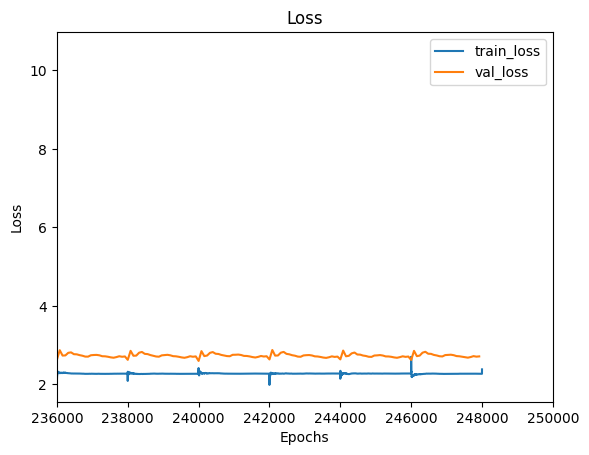

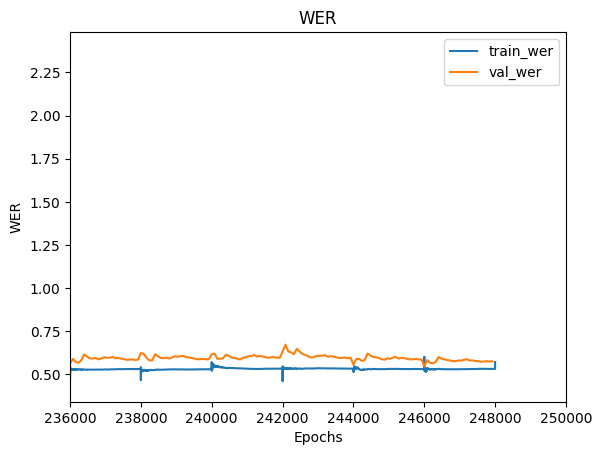

In [131]:
x = []
#print( len( history["train_loss"] ))
for i in range( len( history["train_loss"] )):
    x.append( i )
    
v_x = []
#print( len( history["val_loss"]) )
for i in range( len( history["val_loss"]) ):
    v_x.append( i * 80  )

plt.title( "Loss")
plt.xlabel( "Epochs")
plt.ylabel( "Loss")
plt.plot(x, history["train_loss"], label="train_loss")
plt.plot( v_x, history["val_loss"], label="val_loss")
plt.xlim( 236000, 250000 )
plt.legend()
plt.show()
'''
plt.title( "Accuracy")
plt.xlabel( "Epochs")
plt.ylabel( "Accuracy")
plt.plot(x, history["train_acc"], label="train_acc")
plt.plot( v_x, history["val_acc"], label="val_acc")
plt.legend()
plt.show()
'''
plt.title( "WER")
plt.xlabel( "Epochs")
plt.ylabel( "WER")
plt.plot(x, history["train_wer"], label="train_wer")
plt.plot( v_x, history["val_wer"], label="val_wer")
plt.xlim( 236000, 250000 )
#plt.xlim( 66000, 80000 )
plt.legend()
plt.show()

In [132]:
@torch.no_grad()
def inference(features: torch.Tensor, max_length: int=40):

    bs = features.size(0)
    
    seq_len_src = features.shape[1]
    #seq_len_src = text.shape[1]

    padding_mask_src = (features == idx_list['<pad>'])
    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    
    model.eval()
    enc_out = model.encoder( features, mask_src, padding_mask_src )
    
    # <start> トークンで出力キャプションを初期化
    captions = features.new_full(
        (bs, 1), idx_list_en['<sos>'], dtype=torch.int64)
    
    #print( "enc_out:", enc_out )
    # 単語を逐次予測
    for _ in range(max_length):
        seq_len_tgt = captions.shape[1]
        #mask_tgt = nn.Transformer.generate_square_subsequent_mask( captions.size(1), dtype=bool ).to(device)
        mask_tgt = nn.Transformer.generate_square_subsequent_mask( seq_len_tgt, dtype=bool ).to(device)
        #padding_mask_tgt = (captions == idx_list_en['<pad>']).bool()
        padding_mask_tgt = (captions == idx_list_en['<pad>'])
        #print( "captions:",captions)
        #preds = model.decoder(enc_out, captions, causal_mask = None, dec_padding_mask = dec_padding_mask  )
        model.eval()
        #preds = model.decoder(enc_out, captions, padding_mask_src, None, mask_tgt = None )    
        #preds = model.decoder(enc_out, captions, padding_mask_src, tgt_padding_mask=padding_mask_tgt, tgt_mask = mask_tgt )
        preds = model.decoder(enc_out, captions, padding_mask_src, tgt_padding_mask=padding_mask_tgt, tgt_mask = mask_tgt )
        #preds = model.decoder(enc_out, captions, causal_mask = None, dec_padding_mask = None  )
        preds = preds[:, -1]
        preds = preds.argmax(dim=1)
        #print("preds:",preds)
        words = torch.unsqueeze( preds, dim = 1 )
        
        captions = torch.cat((captions, words), dim=1)

    return captions

In [133]:
@torch.no_grad()
def beam_search(input_sequence):
    ''' ネットワーク計算(forward処理)の関数
    input_sequence: 各発話の入力系列 [B x Tin x D]
    input_lengths:  各発話の系列長(フレーム数) [B]
        []の中はテンソルのサイズ
        B:    ミニバッチ内の発話数(ミニバッチサイズ)
        Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
        D:    入力次元数(dim_in)
        Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
    '''
    predictions = 20
    beam_width = 5
    batch_size = input_sequence.size(0)
        
    enc_mask = input_sequence.eq(idx_list['<pad>']).to(device)
    dec_mask = enc_mask
        
    # エンコーダに入力する
    model.eval()
    enc_out = model.encoder(input_sequence, None, enc_mask)
        
    #enc_lengths = input_lengths
        
    X = torch.ones( (enc_out.size(0), 1 ), dtype=torch.int64  ) * idx_list_en['<sos>']

    dec_target_mask = X.eq(idx_list_en['<pad>']).to(device)
    n_ctx = X.size(1)
    causal_mask = torch.empty(n_ctx, n_ctx).fill_(1).triu_(1).to(device).bool()

    #dec_out= model.decoder( enc_out, X, dec_mask, dec_target_mask, causal_mask )
    #preds = model.decoder(enc_out, captions, padding_mask_src, None, mask_tgt )   
    #logits = self.classifier( dec_out )
    model.eval()
    logits= model.decoder( enc_out, X, dec_mask, dec_target_mask, causal_mask )
    next_probabilities = logits[:, -1, :]
    vocabulary_size = next_probabilities.shape[-1]
    probabilities, idx = next_probabilities.squeeze().log_softmax(-1)\
        .topk(k = beam_width, axis = -1)
    X = X.repeat((beam_width, 1, 1)).transpose(0, 1)\
        .flatten(end_dim = -2)
    next_chars = idx.reshape(-1, 1)
    X = torch.cat((X, next_chars), axis = -1)
    # This has to be minus one because we already produced a round
    # of predictions before the for loop.
    predictions_iterator = range(predictions - 1)

    for i in predictions_iterator:
        dataset = tud.TensorDataset(X)
        loader = tud.DataLoader(dataset, batch_size = batch_size)
        next_probabilities = []
        iterator = iter(loader)
        for (x,) in iterator:
            dec_target_mask = x.eq(idx_list_en['<pad>']).to(device)
            n_ctx = x.size(1)
            causal_mask = torch.empty(n_ctx, n_ctx).fill_(1).triu_(1).to(device).bool()
            #dec_out= model.decoder( enc_out, x, dec_mask, dec_target_mask, causal_mask )
            #logits = self.classifier( dec_out )
            model.eval()
            #logits = model.decoder( enc_out, x, dec_mask, dec_target_mask, causal_mask )
            logits = model.decoder(enc_out, x, dec_mask,  tgt_padding_mask=dec_target_mask, tgt_mask = causal_mask )
            next_probabilities0 = logits[:, -1, :].log_softmax(-1)
            next_probabilities.append(
                next_probabilities0
            )
        next_probabilities = torch.cat(next_probabilities, axis = 0)
        next_probabilities = next_probabilities.reshape(
            (-1, beam_width, next_probabilities.shape[-1])
        )
        probabilities = probabilities.unsqueeze(-1) + next_probabilities
        probabilities = probabilities.flatten(start_dim = 1)
        probabilities, idx = probabilities.topk(
            k = beam_width, 
            axis = -1
        )
        next_chars = torch.remainder(idx, vocabulary_size).flatten()\
            .unsqueeze(-1)
        best_candidates = (idx / vocabulary_size).long()
        best_candidates += torch.arange(
            X.shape[0] // beam_width, 
            device = X.device
        ).unsqueeze(-1) * beam_width
        X = X[best_candidates].flatten(end_dim = -2)
        X = torch.cat((X, next_chars), axis = 1)
        
        #print( "size of X:{}", X.size() )
        
    output = X.reshape( input_sequence.size(0), beam_width, -1 )
    return output[:,0,:]
    #return output


In [134]:
test_print_coef = 10

history = {"test_loss": [], "test_wer": [] }

n = 0

f_test = open( "test_it.log", mode="w", encoding = "UTF-8" )

tes_global_step = 0

model.eval()
print( "Test")
total_wer = 0
n = 0
print("\n-----------------Test Mode-----------------\n")
for i, (src, src_len, tar, tar_len) in enumerate(test_loader):
    tes_global_step += 1
    display = True
    src = src[:,:max(src_len)].to(device)
    tar = tar[:,:max(tar_len)]
    #tar1 = tar[:,:-1]
    #tar2 = tar[:,1:]

    preds = inference( src )
    #preds = inference2( src, tar1 )
    #preds = beam_search( src )
    #logits = model( src, tar1  )
    #preds = torch.argmax( logits, dim = 2 )

    pre_label_id = preds
    predict = []
    for pre in pre_label_id:
        hypo = []
        for m in pre:
            hypo.append(token_list_en[m.item()])
            if token_list_en[m.item()] == '<eos>':
                break            
        predict.append( hypo )
    target = []
    for pre in tar:
    #for pre in tar2:
        reference = []
        for m in pre:
            reference.append(token_list_en[m.item()])
            if token_list_en[m.item()] == '<eos>':
                break            
        target.append( reference )
    total_error = 0
    # 文字の総数を累積する
    total_token_length = 0
    for i3, (pred, tar) in enumerate( zip(predict, target) ):
        (error, substitute, 
            delete, insert, ref_length) = \
            levenshtein.calculate_error(pred,tar)
        # 誤り文字数を累積する
        total_error += error
        # 文字の総数を累積する
        total_token_length += ref_length  

        print( "pred:", ' '.join(pred) )
        print( "tar: ", ' '.join(tar) )
            
    test_wer = total_error / total_token_length
    total_wer += test_wer
    n += 1

    history["test_wer"].append( test_wer / n )
    print(f"epoch:{epoch+1}  Step:{tes_global_step}  WER:{ test_wer :.10f}")
    f_test.write( "Epoch: " + str(epoch) + ", Step: " + str(tes_global_step) + ", WER: " + str(test_wer ) + "\n" )
    f_test.flush()

f_test.close()
print(f"epoch:{epoch+1}  Step:{tes_global_step}  avg_WER:{ total_wer / n:.10f}")

Test

-----------------Test Mode-----------------

pred: <sos> we all know that the cost of saving the cost of savings is now less expensive than it is also the result of a growth and employment policy which must stimulate growth <eos>
tar:  <sos> we all know that the cost of saving is now lower than the cost of new production it follows that taking action to save energy also promotes growth and employment <eos>
pred: <sos> this is not a political group which is a real <unk> of national citizens' lives and will be growing in the growing number of national policies in the areas of the european union <eos>
tar:  <sos> a political elite with no genuine mandate from the people <unk> roughshod over the public and their national institutions in ever more areas of political life <eos>
pred: <sos> when money is used everything is done <eos>
tar:  <sos> when the money is used all is well <eos>
pred: <sos> mr <unk> has referred to the considerations of the comitology <eos>
tar:  <sos> mr seeber 